В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [188]:
import pandas as pd

train_data = pd.read_csv('train.csv')
train_data.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [189]:
from sklearn.model_selection import train_test_split


X = train_data.drop('Exited', axis=1)
y = train_data['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [191]:
input_cols = X.columns.tolist() 
target_col = 'Exited'  

train_inputs = X_train[input_cols]  
train_targets = y_train  

val_inputs = X_val[input_cols] 
val_targets = y_val  

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [193]:
import numpy as np

numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

numeric_cols, categorical_cols

(['id',
  'CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [195]:
train_data.shape

(15000, 14)

In [196]:
train_data[numeric_cols].isna().sum()

id                 0
CustomerId         0
CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [197]:
train_data[categorical_cols].isna().sum()

Surname      0
Geography    0
Gender       0
dtype: int64

Пропущених значень немає

In [199]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [200]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [201]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [202]:
encoder.categories_

[array(['Achebe', 'Ahern', 'Aikenhead', 'Aitken', 'Akabueze', 'Akhtar',
        'Akobundu', 'Aksakova', 'Aksenov', 'Aksenova', 'Aksyonov',
        'Aksyonova', 'Atherton', 'Avent', 'Azikiwe', 'Azubuike', 'Babbage',
        'Baddeley', 'Bage', 'Bair', 'Bales', 'Balsillie', 'Bancks',
        'Bancroft', 'Baresi', 'Baryshnikov', 'Bazarova', 'Bell',
        'Bellucci', 'Bergamaschi', 'Bess', 'Bevan', 'Bibi', 'Binder',
        'Biryukov', 'Biryukova', 'Bischof', 'Bitter', 'Black', 'Blesing',
        'Bock', 'Bogle', 'Boulger', 'Bovee', 'Brazenor', 'Brient',
        'Brierly', 'Brown', 'Brownless', 'Buchi', 'Bufkin', 'Burdekin',
        'Burns', 'Burt', 'Burtch', 'Cairns', 'Calabrese', 'Calabresi',
        'Cameron', 'Cattaneo', 'Cavenagh', 'Cawker', 'Cawood', 'Cawthorne',
        "Ch'ang", "Ch'en", "Ch'eng", "Ch'ien", "Ch'in", "Ch'iu", 'Cheng',
        'Chia', 'Chiabuotu', 'Chiagoziem', 'Chialuka', 'Chiang',
        'Chiawuotu', 'Chiazagomekpele', 'Chiazagomekpere', 'Chibueze',
        'Chi

In [203]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
encoder.transform(train_inputs[categorical_cols])

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [204]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [205]:
display(train_inputs.head(5))
display(val_inputs.head(5))

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Surname_Zikoranachidimma,Surname_Zito,Surname_Zox,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
8263,0.550903,0.990418,Toscani,0.632458,France,Male,0.259259,0.5,0.622726,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
14199,0.946663,0.999239,Kuo,0.479714,Germany,Female,0.259259,0.4,0.571232,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1856,0.123742,0.985771,Ejimofor,0.591885,France,Female,0.074074,0.4,0.000000,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3013,0.200880,0.988497,Onochie,0.653938,France,Male,0.555556,0.3,0.000000,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8266,0.551103,0.996683,Chukwuemeka,0.632458,France,Female,0.314815,0.7,0.000000,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Surname_Zikoranachidimma,Surname_Zito,Surname_Zox,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
1855,0.123675,0.995468,Bitter,0.267303,France,Male,0.203704,0.9,0.570579,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1273,0.084872,0.990856,Ting,0.398568,Germany,Male,0.425926,0.3,0.590481,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5414,0.360957,0.992607,Maclean,0.453461,France,Male,0.240741,0.7,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
10923,0.728249,0.985575,Chiang,0.396181,France,Male,0.703704,0.3,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5835,0.389026,0.997419,Oluchi,0.758950,Spain,Female,0.444444,0.5,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [207]:
# !pip install pyarrow --quiet

In [208]:
train_targets_df = train_targets.to_frame()
val_targets_df = val_targets.to_frame()

train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
train_targets_df.to_parquet('train_targets.parquet')
val_targets_df.to_parquet('val_targets.parquet')

In [209]:
import os
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 'Anaconda3-2024.06-1-Windows-x86_64.exe',
 'desktop.ini',
 'full_query_2024-10-07T13_56_05.448928Z.csv',
 'full_query_2024-10-07T14_51_53.077532Z.xlsx',
 'full_query_2024-10-08T06_35_18.725978Z.xlsx',
 'full_query_2024-10-08T06_57_07.658802Z.xlsx',
 'HW_2_2_Логістична_регресія_з_scikit_learn.ipynb',
 'last_query_with_product_filter_2024-10-09T10_20_09.130825Z.xlsx',
 'last_query_with_product_filter_2024-10-09T13_09_11.92282Z.xlsx',
 'last_query_with_product_filter_2024-10-09T13_34_14.029702Z.xlsx',
 'last_query_with_product_filter_2024-10-11T15_31_27.59054Z.xlsx',
 'log_reg.joblib',
 'PBIDesktopSetup.exe',
 'percent_pays_by_statuses_2024-09-27T09_31_51.567663Z.xlsx',
 'percent_pays_by_statuses_2024-09-27T09_33_56.782233Z.xlsx',
 'percent_pays_by_statuses_2024-09-27T11_13_46.564406Z.xlsx',
 'percent_pays_by_statuses_2024-09-27T13_11_19.28106Z.xlsx',
 'query_result_2024-09-18T08_30_30.181814Z.xlsx',
 'query_result_2024-09-18T10_16_23.588984Z.xlsx',
 'query_result_

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [211]:
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]

In [212]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (11250, 738)
train_targets: (11250,)
val_inputs: (3750, 738)
val_targets: (3750,)


In [213]:
numeric_cols

['id',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [214]:
# numeric_cols = ['CreditScore',
#  'Age',
#  'Tenure',
#  'Balance',
#  'NumOfProducts',
#  'HasCrCard',
#  'IsActiveMember',
#  'EstimatedSalary']

In [215]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [216]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [217]:
print(numeric_cols + encoded_cols)

['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Surname_Achebe', 'Surname_Ahern', 'Surname_Aikenhead', 'Surname_Aitken', 'Surname_Akabueze', 'Surname_Akhtar', 'Surname_Akobundu', 'Surname_Aksakova', 'Surname_Aksenov', 'Surname_Aksenova', 'Surname_Aksyonov', 'Surname_Aksyonova', 'Surname_Atherton', 'Surname_Avent', 'Surname_Azikiwe', 'Surname_Azubuike', 'Surname_Babbage', 'Surname_Baddeley', 'Surname_Bage', 'Surname_Bair', 'Surname_Bales', 'Surname_Balsillie', 'Surname_Bancks', 'Surname_Bancroft', 'Surname_Baresi', 'Surname_Baryshnikov', 'Surname_Bazarova', 'Surname_Bell', 'Surname_Bellucci', 'Surname_Bergamaschi', 'Surname_Bess', 'Surname_Bevan', 'Surname_Bibi', 'Surname_Binder', 'Surname_Biryukov', 'Surname_Biryukova', 'Surname_Bischof', 'Surname_Bitter', 'Surname_Black', 'Surname_Blesing', 'Surname_Bock', 'Surname_Bogle', 'Surname_Boulger', 'Surname_Bovee', 'Surname_Brazenor', 'Surname_Brient', 'Surna

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [219]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 88.38%


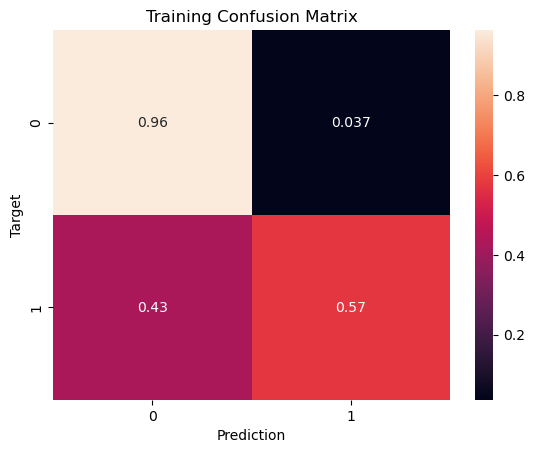

In [220]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 87.09%


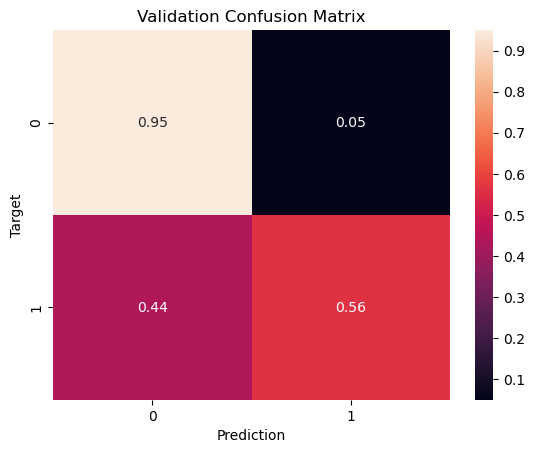

In [221]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

AUROC for Training: 0.90


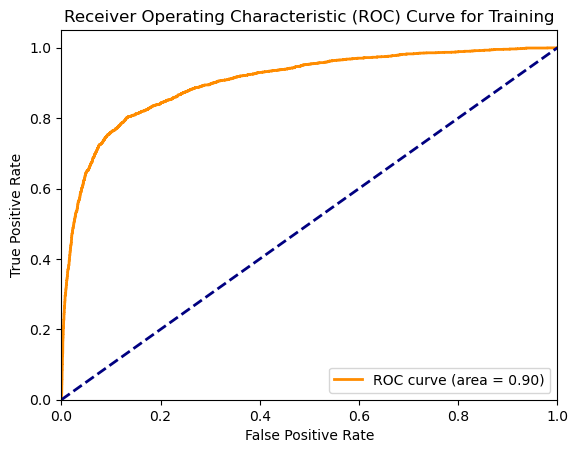

AUROC for Validation: 0.88


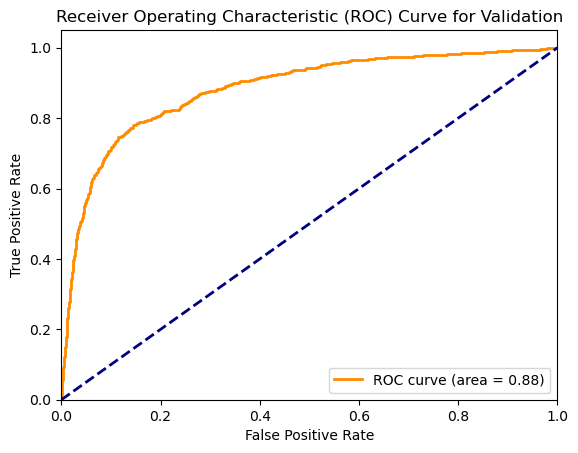

In [222]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(inputs, targets, name=''):
    # Predict probabilities
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)

    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.2f}')

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

In [223]:
from sklearn.metrics import f1_score

def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds, pos_label=1)
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')

F1 score Training: 0.67%
F1 score Validation: 0.64%


Модель демонструє високу ефективність з AUROC 0.90 (на тренувальних даних) і 0.88 (на валідаційних), що свідчить про відмінну здатність розрізняти класи, а також високу точність (88.42% на тренуванні, 87.09% на валідації), що вказує на хорошу модель. Модель має F1-скор 0.67 на тренувальних даних і 0.64 на валідаційних, що показує, що вона добре збалансована

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [226]:
majority_class = train_targets.mode()[0]

majority_preds_train = [majority_class] * len(train_targets)
majority_preds_val = [majority_class] * len(val_targets)

accuracy_majority_train = accuracy_score(train_targets, majority_preds_train)
accuracy_majority_val = accuracy_score(val_targets, majority_preds_val)

accuracy_model_train = accuracy_score(train_targets, model.predict(X_train))
accuracy_model_val = accuracy_score(val_targets, model.predict(X_val))

print(f"Accuracy мажоритарної моделі (Train): {accuracy_majority_train:.2f}")
print(f"Accuracy мажоритарної моделі (Validation): {accuracy_majority_val:.2f}")
print(f"Accuracy натренованої моделі (Train): {accuracy_model_train:.2f}")
print(f"Accuracy натренованої моделі (Validation): {accuracy_model_val:.2f}")

Accuracy мажоритарної моделі (Train): 0.80
Accuracy мажоритарної моделі (Validation): 0.80
Accuracy натренованої моделі (Train): 0.88
Accuracy натренованої моделі (Validation): 0.87


Наша модель передбачає трохи краще, ніж ми би всюди призначили мажоритарний клас. Можна краще, але 87% на валідації все ж досить непогано

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [229]:
import joblib

joblib.dump({
    'model': model,
    'majority_class': majority_class,
}, 'log_reg.joblib')

['log_reg.joblib']

In [230]:
loaded_objects = joblib.load('log_reg.joblib')

model_2 = loaded_objects['model']
majority_class_loaded = loaded_objects['majority_class']

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [232]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [234]:
probabilities = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, train_data[:5])
print(probabilities)


[0.00554838 0.03112407 0.49511048 0.31155936 0.97032475]


11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [236]:
test_raw_df = pd.read_csv('test.csv')
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Surname_Zito,Surname_Zox,Surname_Zuyev,Surname_Zuyeva,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,1.000067,0.984482,Chu,0.365155,Germany,Male,0.222222,0.2,0.696265,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.023900
1,1.000133,0.987856,Mazzi,0.286396,France,Male,0.388889,0.5,0.000000,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.053627
2,1.000200,0.993017,Onyekachi,0.656325,France,Male,0.462963,0.8,0.000000,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.074095
3,1.000267,0.997849,Martin,0.682578,Spain,Male,0.500000,0.3,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.304919
4,1.000333,0.989270,Kenechukwu,0.384248,Spain,Male,0.462963,0.8,0.000000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.044088


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [238]:
sample_submission_df = pd.read_csv('sample_submission.csv')

predicted_probabilities = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)
sample_submission_df['Exited'] = predicted_probabilities

sample_submission_df.to_csv('submission_log_reg.csv', index=False)
sample_submission_df.head(5)

,id,Exited
0,15000,0.019975
1,15001,0.013751
2,15002,0.014153
3,15003,0.023605
4,15004,0.006521
